### Libraries

In [20]:
from scipy.stats import norm
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

### Functions

In [2]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)


# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

### Data

In [3]:
data_ = load_data(download_data())
print(data_.shape)
data_.head()

100%|██████████| 0.98M/0.98M [00:00<00:00, 4.95MB/s]

Extracting files...
(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df = data_[["default.payment.next.month", "LIMIT_BAL", "ID"]].copy()
df.rename(
    columns={
        "LIMIT_BAL": "CREDIT_LINE",
        "default.payment.next.month": "DEFAULT_STATUS",
    },
    inplace=True,
)
print(df.shape)
df.head()

(30000, 3)


,DEFAULT_STATUS,CREDIT_LINE,ID
0,1,20000.0,1
1,1,120000.0,2
2,0,90000.0,3
3,0,50000.0,4
4,0,50000.0,5


In [5]:
credit_lines = df.CREDIT_LINE.values
credit_lines

array([ 20000., 120000.,  90000., ...,  30000.,  80000.,  50000.],
      shape=(30000,))

### Parameter values

In [6]:
correlation_factor = 0.04  # Correlation between defaults
# payment_default = [0.03, 0.15]          # Payment Default Range
payment_default = 0.05  # Payment Default
threshold = norm.ppf(payment_default)

In [7]:
# n_default = 0
# total_amount_losses = []
# n_losses = []

N = len(credit_lines)
n_simulations = 1000

total_losses = np.zeros(n_simulations)
n_user_default = np.zeros(n_simulations)

### Simulation

In [8]:
for i in range(n_simulations):
    systematic_factor = np.random.normal(0, 1)  # Economic environment
    idiosyncratic_factor = np.random.normal(0, 1, N)  # Individual factor

    # Vasicek Formula
    X = (
        np.sqrt(correlation_factor) * systematic_factor
        + np.sqrt(1 - correlation_factor) * idiosyncratic_factor
    )

    flag = (X < threshold).astype(int)
    n_user_default[i] = np.sum(flag)
    total_losses[i] = np.sum(flag * credit_lines)

In [25]:
print(f"Default Rate: {payment_default:.2%}")
print(f"Correlation rate: {correlation_factor}\n")

expected_loss = np.mean(total_losses)

print(f"Number of simulations: {n_simulations}\n")
print(f"Mean default rate: {np.mean(n_user_default)/N:.2%}")
print(f"Mean loss amount: ${expected_loss:,.2f}\n")

print(
    f"Worst scenario: {np.max(n_user_default):.0f} defaults (${np.max(total_losses):,.0f})"
)
print(
    f"Best scenario: {np.min(n_user_default):.0f} defaults (${np.min(total_losses):,.0f})"
)

Default Rate: 5.00%
Correlation rate: 0.04

Number of simulations: 1000

Mean default rate: 4.91%
Mean loss amount: $247,005,481.52

Worst scenario: 4604 defaults ($767,380,000)
Best scenario: 186 defaults ($33,040,000)


In [19]:
confidence1 = 90
VaR_90 = np.percentile(total_losses, confidence1)
expected_shortfall_90 = np.mean(total_losses[total_losses >= VaR_90])

print(f"{confidence1}% VaR: NT${VaR_90:,.2f}")

# this means there is a 90% of losing up to VaR_90 amount in the portfolio over a given time horizon
# so there is a 10% chance of losing more than that amount

print(f"{confidence1}% Expected Shortfall: NT${expected_shortfall_90:,.2f}")
# this means that in the worst 10% of cases (100 - confidence1), the expected loss amount is expected_shortfall_90 (cvar)

confidence2 = 95
VaR_95 = np.percentile(total_losses, confidence2)
expected_shortfall_95 = np.mean(total_losses[total_losses >= VaR_95])


print(f"{confidence2}% VaR: NT${VaR_95:,.2f}")

# this means there is a 95% of losing up to VaR_95 amount in the portfolio over a given time horizon
# so there is a 5% chance of losing more than that amount

print(f"{confidence2}% Expected Shortfall: NT${expected_shortfall_95:,.2f}")
# this means that in the worst 5% of cases (100 - confidence2), the expected loss amount is expected_shortfall_95 (cvar)

confidence3 = 99
VaR_99 = np.percentile(total_losses, confidence3)
expected_shortfall_99 = np.mean(total_losses[total_losses >= VaR_99])

print(f"{confidence3}% VaR: NT${VaR_99:,.2f}")

# this means there is a 99% of losing up to VaR_99 amount in the portfolio over a given time horizon
# so there is a 1% chance of losing more than that amount

print(f"{confidence3}% Expected Shortfall: NT${expected_shortfall_99:,.2f}")
# this means that in the worst 1% of cases (100 - confidence3), the expected loss amount is expected_shortfall_99 (cvar)

90% VaR: NT$385,138,000.00
90% Expected Shortfall: NT$470,268,327.20
95% VaR: NT$451,611,000.00
95% Expected Shortfall: NT$526,684,307.20
99% VaR: NT$566,420,200.00
99% Expected Shortfall: NT$621,085,000.00


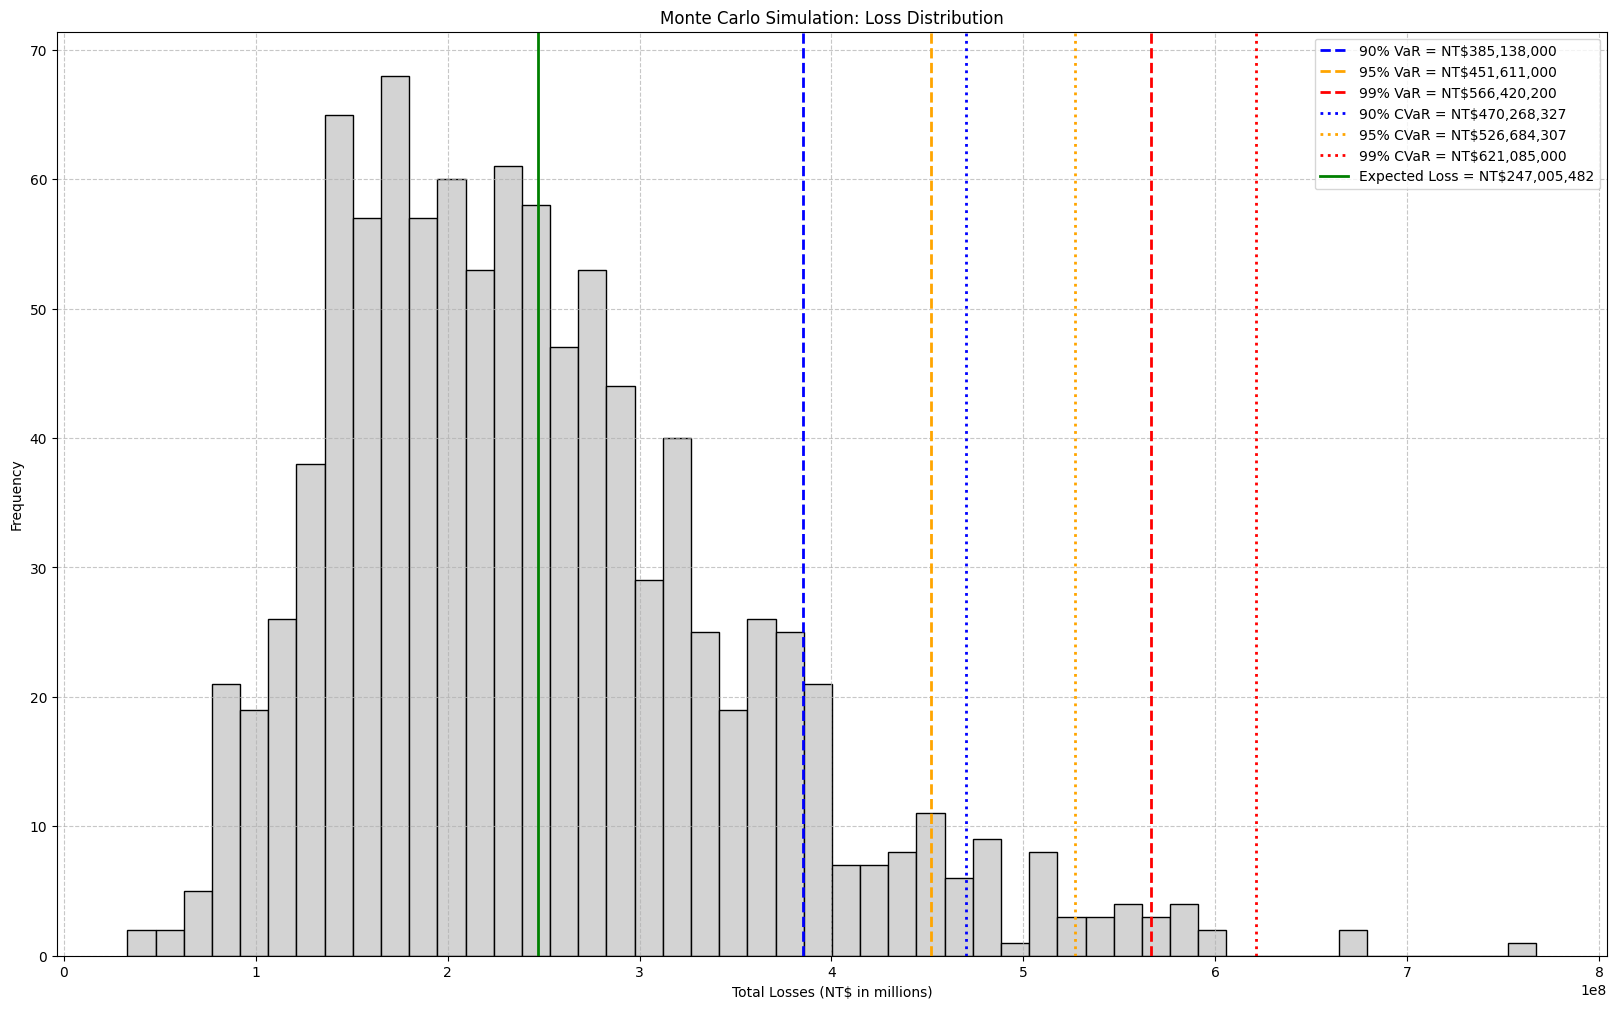

In [ ]:

# Plot histogram of total losses
plt.figure(figsize=(20, 12))
plt.hist(total_losses, bins=50, color='lightgray', edgecolor='black')
plt.title("Monte Carlo Simulation: Loss Distribution")
plt.xlabel("Total Losses (NT$ in hundreds of millions)")
plt.ylabel("Frequency")

# Add VaR and Expected Shortfall lines
plt.axvline(VaR_90, color='blue', linestyle='--', linewidth=2, label=f'90% VaR = NT${VaR_90:,.0f}')
plt.axvline(VaR_95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR = NT${VaR_95:,.0f}')
plt.axvline(VaR_99, color='red', linestyle='--', linewidth=2, label=f'99% VaR = NT${VaR_99:,.0f}')

plt.axvline(expected_shortfall_90, color='blue', linestyle=':', linewidth=2, label=f'90% CVaR = NT${expected_shortfall_90:,.0f}')
plt.axvline(expected_shortfall_95, color='orange', linestyle=':', linewidth=2, label=f'95% CVaR = NT${expected_shortfall_95:,.0f}')
plt.axvline(expected_shortfall_99, color='red', linestyle=':', linewidth=2, label=f'99% CVaR = NT${expected_shortfall_99:,.0f}')

# Expected (average) loss line
plt.axvline(expected_loss, color='green', linestyle='-', linewidth=2, label=f'Expected Loss = NT${expected_loss:,.0f}')
# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [34]:
print("\n" + "="*60)
print("SUMMARY STATISTICS - SIMULATION RESULTS")
print("="*60)

print("SIMULATION PARAMETERS:")
print(f"   • Number of simulations: {len(total_losses):,}")
print(f"   • Portfolio size: 30,000 clients")  # adjust if you store N separately
print(f"   • Probability of Default (PD): {payment_default:.2%}")
print(f"   • Correlation (ρ): {correlation_factor}")

print(f"\nLOSS STATISTICS:")
expected_loss = np.mean(total_losses)
print(f"   • Expected Loss: NT${expected_loss:,.2f}")
print(f"   • Minimum Loss: NT${np.min(total_losses):,.2f}")
print(f"   • Maximum Loss: NT${np.max(total_losses):,.2f}")
print(f"   • Loss Standard Deviation: NT${np.std(total_losses):,.2f}")

print(f"\n⚠ RISK METRICS:")
print(f"   • VaR 90%: NT${VaR_90:,.2f}")
print(f"   • VaR 95%: NT${VaR_95:,.2f}")
print(f"   • VaR 99%: NT${VaR_99:,.2f}")
print(f"   • CVaR 90%: NT${expected_shortfall_90:,.2f}")
print(f"   • CVaR 95%: NT${expected_shortfall_95:,.2f}")
print(f"   • CVaR 99%: NT${expected_shortfall_99:,.2f}")

print(f"\nINTERPRETATION:")
print(f"   • In 90 of every 100 periods, losses won’t exceed NT${VaR_90:,.0f}")
print(f"   • In 95 of every 100 periods, losses won’t exceed NT${VaR_95:,.0f}")
print(f"   • In 99 of every 100 periods, losses won’t exceed NT${VaR_99:,.0f}")
print(f"   • In the worst 10% of cases, average loss = NT${expected_shortfall_90:,.0f}")
print(f"   • In the worst 5% of cases, average loss = NT${expected_shortfall_95:,.0f}")
print(f"   • In the worst 1% of cases, average loss = NT${expected_shortfall_99:,.0f}")
print(f"   • Maximum observed loss: NT${np.max(total_losses):,.0f}")

print("="*60)



SUMMARY STATISTICS - SIMULATION RESULTS
SIMULATION PARAMETERS:
   • Number of simulations: 1,000
   • Portfolio size: 30,000 clients
   • Probability of Default (PD): 5.00%
   • Correlation (ρ): 0.04

LOSS STATISTICS:
   • Expected Loss: NT$247,005,481.52
   • Minimum Loss: NT$33,040,000.00
   • Maximum Loss: NT$767,380,000.00
   • Loss Standard Deviation: NT$106,422,050.90

⚠ RISK METRICS:
   • VaR 90%: NT$385,138,000.00
   • VaR 95%: NT$451,611,000.00
   • VaR 99%: NT$566,420,200.00
   • CVaR 90%: NT$470,268,327.20
   • CVaR 95%: NT$526,684,307.20
   • CVaR 99%: NT$621,085,000.00

INTERPRETATION:
   • In 90 of every 100 periods, losses won’t exceed NT$385,138,000
   • In 95 of every 100 periods, losses won’t exceed NT$451,611,000
   • In 99 of every 100 periods, losses won’t exceed NT$566,420,200
   • In the worst 10% of cases, average loss = NT$470,268,327
   • In the worst 5% of cases, average loss = NT$526,684,307
   • In the worst 1% of cases, average loss = NT$621,085,000
   • 